In [70]:
from __future__ import absolute_import, division, print_function

from os import listdir
import xmltodict
import pandas
from StringIO import StringIO
%matplotlib inline
from tqdm import tqdm
import math
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from praelexis_file_system_provider.data_access_layer import AzureBlobStorageDataAccessLayer
import PyPDF2
import subprocess
import shutil
import os

import pytesseract
from PIL import Image

### Connect to blob storage

In [71]:
blob_dal = AzureBlobStorageDataAccessLayer('devcapitecdata', 'Gt5z0EAAAm5ZETk//WBnRiQUZ9FDB/BmLmbx5ZPRtDwh6vxTDAB/XzLlM+m/epfnDYcZ8JDfMEGg1p9tBW0iFQ==', 'bank-statements', home_directory='drop/Documentum_line_files')

blob_dal.connect()
files = blob_dal.list(path='CI')

print ("Number of files: ", len(files))


Number of files:  8000


In [20]:

print(files[500].name)
print(files[501].name)


0f427a33-cbed-4673-a5d0-79dce1b8d45b.pdf
0f427a33-cbed-4673-a5d0-79dce1b8d45b_POCSTATEMENTSSTD_Capitec__19122017_022834_1154.xml


### Download random pdfs and their xml files

In [72]:
folderLoc = "./TestAllExamples/"

In [9]:
import random
random.seed(1000)
numToTest = 3

for i in tqdm(range(numToTest)):
    randNum = int(len(files)/2.0*random.random())*2-10 
    
    while(files[randNum].name[-3:]!="pdf"):
        randNum-=1

    pdfName = files[randNum].directory + files[randNum].name
    
    matchString = files[randNum].name[:-4]
    #print(matchString)
    if matchString in files[randNum-1].name:
        #print(files[randNum].name," ",files[randNum-1].name)
        xmlName = files[randNum-1].directory + files[randNum-1].name
    else:
        #print ("Else")
        #print(files[randNum].name," ",files[randNum+1].name)
        xmlName = files[randNum+1].directory + files[randNum+1].name
    #print ("Downloading: ", pdfName , " and ", xmlName)
        
    stream = StringIO()
    blob_dal.get(pdfName, stream)
    with open (folderLoc+"Example"+str(i+1)+".pdf", 'w') as tmp:
      stream.seek (0)
      shutil.copyfileobj (stream, tmp)
    
    stream = StringIO()
    blob_dal.get(xmlName, stream)
    with open (folderLoc+"Example"+str(i+1)+".xml", 'w') as tmp:
      stream.seek (0)
      shutil.copyfileobj (stream, tmp)

100%|██████████| 3/3 [00:00<00:00,  6.72it/s]


### Convert and test document 1 document

Command to generate boxes from tesseract

command = 'tesseract ./TestRandomExamples/testText.jpg ./TestRandomExamples/testText  batch.nochop makebox'

In [5]:
import commands
import time
import glob

exampleNumber = 2

%env TESSDATA_PREFIX=/leptonica/tesseract/tessdata

pdfNames = glob.glob(folderLoc+"*.pdf")

fileName = pdfNames[exampleNumber-1]

start = time.time()
s=commands.getstatusoutput("convert -density 300 -units pixelsperinch "+str(fileName)+" -quality 100 "+str(fileName[:-4])+".tif")
print(s)
print("It took ",round(time.time()-start,2)," seconds to convert the pdf.")

start = time.time()
command = "tesseract "+str(fileName[:-4])+".tif "+str(fileName[:-4])+ " -l eng bazaar"
print("Command: ", command)
s=commands.getstatusoutput(command)
print(s)
print("It took ",round(time.time()-start), " to run tesseract on the tif file.")

s=commands.getstatusoutput("convert -density 300 -units pixelsperinch "+str(fileName)+" -quality 100 "+str(fileName[:-4])+".tif")
print(s)
print("It took ",round(time.time()-start,2)," seconds to convert the pdf.")
tifLoc = str(fileName[:-4])+".tif"
print("Deleting the tif file.")
s=commands.getstatusoutput("rm " + tifLoc)
print("Tif deleted. Please check.")

print("Done")

env: TESSDATA_PREFIX=/leptonica/tesseract/tessdata
(0, '')
It took  14.72  seconds to convert the pdf.
Command:  tesseract ./TestRandomExamples/Example2.tif ./TestRandomExamples/Example2 -l eng bazaar


KeyboardInterrupt: 

### Convert and process all pdfs

The pdfs are first converted to tif files. The tif files are then sent through Tesseract. A text file is then generated for each pdf image with the estimated text found using Tesseract.

In [ ]:
#import commands
#s=commands.getstatusoutput("tesseract ./TestRandomExamples/Example1.tif ./TestRandomExamples/Example1 -l eng")
#print(s)

In [ ]:
import commands
import time
import glob

%env TESSDATA_PREFIX=/leptonica/tesseract/tessdata

pdfNames = glob.glob(folderLoc+"*.pdf")

print("Number of pdfs found: ",len(pdfNames))

for i in tqdm(range(len(pdfNames))):
    start = time.time()
    tifLoc = str(pdfNames[i][:-4])+".tif"
    s=commands.getstatusoutput("convert -density 300 -units pixelsperinch "+str(pdfNames[i])+" -quality 100 "+tifLoc)
    print(s)
    print("It took ",round(time.time()-start,2)," seconds to convert the pdf.")

    start = time.time()
    command = "tesseract " + tifLoc + " "+str(pdfNames[i][:-4])+" -l eng"
    print("Command: ", command)
    s=commands.getstatusoutput(command)
    print(s)
    print("It took ",round(time.time()-start), " to run tesseract on the tif file.")
    
    print("Deleting the tif file.")
    s=commands.getstatusoutput("rm " + tifLoc)
    print("Tif deleted. Please check.")
    exit(0)

print("Done")

  0%|          | 0/3 [00:00<?, ?it/s]

env: TESSDATA_PREFIX=/leptonica/tesseract/tessdata
Number of pdfs found:  3
(0, '')
It took  6.8  seconds to convert the pdf.
Command:  tesseract ./TestRandomExamples/Example1.tif ./TestRandomExamples/Example1 -l eng
(0, 'Tesseract Open Source OCR Engine v4.00.00alpha with Leptonica\nPage 1\nPage 2\nPage 3\nPage 4')
It took  49.0  to run tesseract on the tif file.
Deleting the tif file.


 33%|███▎      | 1/3 [00:55<01:51, 55.64s/it]

Tif deleted. Please check.
(0, '')
It took  17.22  seconds to convert the pdf.
Command:  tesseract ./TestRandomExamples/Example2.tif ./TestRandomExamples/Example2 -l eng


KeyboardInterrupt: 

### Test amount value errors

In [28]:
def getValues(fileName):
    f = open(txtNames[i],'r')
    values = []
    line = f.readline()
    while line:

        amountLen = 0
        valueLine = []
        for index,char in enumerate(line):
            
            if amountLen>0:
                if char == '0' or char == '1' or char == '2' or char == '3' or char == '4' or char == '5'or \
                char == '6' or char == '7' or char == '8' or char == '9' or char == ' ' or char == ',' or \
                char == '.' or char == '-' or char == '+':
                    amountLen+=1
                else:
                    if amountLen>1 and line[index-amountLen:index] != "R ":
                        amount = str(line[index-amountLen:index])
                        amount = amount.replace("R", "")
                        amount = amount.replace(",", "")
                        amount = amount.replace(" ", "")
                        amount = amount.replace(".", "")
                        valueLine.append(amount)
                        #print(amount)
                        
                        if len(valueLine)==2:
                            break
                        
                    amountLen = 0
                    
            if char == 'R' and amountLen==0 and (len(valueLine)>0 or line[index-1] == ' '):
                amountLen = 1
        if len(valueLine)>0:
            values.append(valueLine)
        line = f.readline()
    return values
    
def getResult(values):
    possibleAlt = 0.0
    right = 0.0
    total = 0
    skip = 0
    for base in range(1,len(values)):
        i = base# + skip
        try:
            #print(values[i])
            if len(values[i])==2:
                if round(float(values[i][1])-float(values[i][0]),2) == round(float(values[i-1][len(values[i-1])-1]),2):
                    right+=1
                else:
                    skip += 1
                    #print("Wrong. Ans: ", float(values[i][1])," minus ",float(values[i][0])," must equal ",float(values[i-1][len(values[i-1])-1]), ". But true subtraction: ",round(float(values[i][1])-float(values[i][0]),2))
                total += 1
        except:
            #print("Not a number.")
            total +=1
    
    return round(right/total,2) if total>0 else 0.0,total

In [110]:
import glob
txtNames = glob.glob(folderLoc+"*.txt")
print("Number of textfiles found: ",len(txtNames))
result = np.zeros(len(txtNames))
for i in tqdm(range(len(txtNames))):
    print("File number: ",str(i+1))
    print("File name: ",txtNames[i])
    
    values = getValues(txtNames[i])
    
    res,total = getResult(values)
    result[i] = res
    print("Number of values tested: ",total)
    print("Accuracy: ", res," out of 1.\n")

 42%|████▏     | 28/66 [00:00<00:00, 275.56it/s]

Number of textfiles found:  66
File number:  1
File name:  ./TestAllExamples/Example41.txt
Number of values tested:  100
Accuracy:  0.0  out of 1.

File number:  2
File name:  ./TestAllExamples/Example40.txt
Number of values tested:  204
Accuracy:  0.5  out of 1.

File number:  3
File name:  ./TestAllExamples/Example42.txt
Number of values tested:  100
Accuracy:  0.0  out of 1.

File number:  4
File name:  ./TestAllExamples/Example45.txt
Number of values tested:  59
Accuracy:  0.92  out of 1.

File number:  5
File name:  ./TestAllExamples/Example46.txt
Number of values tested:  59
Accuracy:  0.92  out of 1.

File number:  6
File name:  ./TestAllExamples/Example49.txt
Number of values tested:  213
Accuracy:  0.35  out of 1.

File number:  7
File name:  ./TestAllExamples/Example50.txt
Number of values tested:  213
Accuracy:  0.35  out of 1.

File number:  8
File name:  ./TestAllExamples/Example1.txt
Number of values tested:  123
Accuracy:  0.84  out of 1.

File number:  9
File name:  ./T

100%|██████████| 66/66 [00:00<00:00, 319.41it/s]

Number of values tested:  209
Accuracy:  0.87  out of 1.

File number:  63
File name:  ./TestAllExamples/Example63.txt
Number of values tested:  36
Accuracy:  0.86  out of 1.

File number:  64
File name:  ./TestAllExamples/Example64.txt
Number of values tested:  36
Accuracy:  0.86  out of 1.

File number:  65
File name:  ./TestAllExamples/Example65.txt
Number of values tested:  71
Accuracy:  0.82  out of 1.

File number:  66
File name:  ./TestAllExamples/Example66.txt
Number of values tested:  0
Accuracy:  0.0  out of 1.



### Plot the results

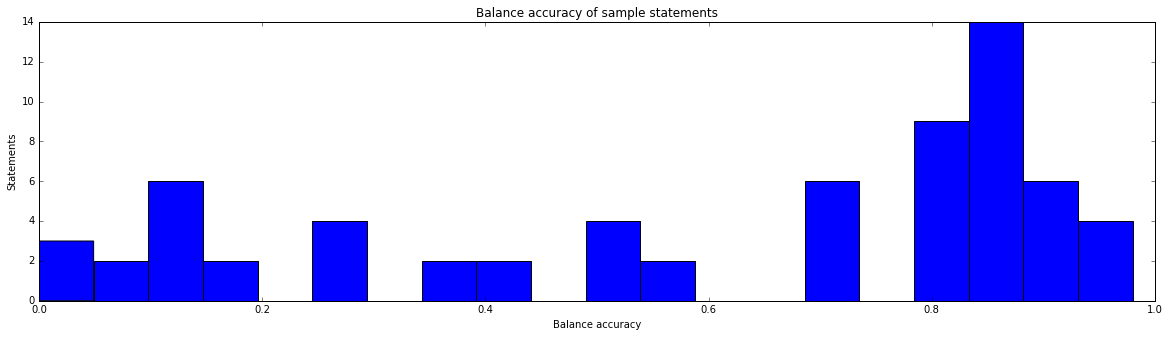

In [111]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
x = result#np.random.normal(size = 1000)
plt.figure(figsize=(20,5))
plt.hist(x, bins=20)
plt.title('Balance accuracy of sample statements')
plt.xlabel('Balance accuracy')
plt.ylabel('Statements')

### Read the xml and output using pandas

In [ ]:
import xml.etree.cElementTree as et
import pandas as pd
 
def getvalueofnode(node):
    """ return node text or None """
    return node.text if node is not None else None
 
""" main """
path = './TestExamples/Example1.xml'
parsed_xml = et.parse(path)
dfcols = ['postdate', 'description','fee','payments','deposits','balance']
df_xml = pd.DataFrame(columns=dfcols)
child = parsed_xml.getroot().getchildren()[2].getchildren()
for node in child:
    postdate = node.find('postdate')
    description = node.find('description')
    fee = node.find('fee')
    payments = node.find('payments')
    deposits = node.find('deposits')
    balance = node.find('balance')

    df_xml = df_xml.append(
        pd.Series([getvalueofnode(postdate),
                   getvalueofnode(description),
                   getvalueofnode(fee),
                   getvalueofnode(payments),
                   getvalueofnode(deposits),
                   getvalueofnode(balance)], index=dfcols),
        ignore_index=True)

print df_xml